# **Regression Model to Calculate User Daily Calorie Intake**

## **1. Importing Libraries and Loading Data**

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

data_path = 'bodyPerformance.csv'
data = pd.read_csv(data_path)

## **2. Selecting and Cleaning Data**

In [3]:
data = data[['age', 'gender', 'height_cm', 'weight_kg']]

data.dropna(inplace=True)

data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

for col in ['height_cm', 'weight_kg']:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]


## **3. Calculating BMR**

In [4]:
def calculate_bmr(row):
    if row['gender'] == 1:
        return 88.362 + (13.397 * row['weight_kg']) + (4.799 * row['height_cm']) - (5.677 * row['age'])
    else:
        return 447.593 + (9.247 * row['weight_kg']) + (3.098 * row['height_cm']) - (4.330 * row['age'])

df = pd.DataFrame(data)
df['BMR'] = df.apply(calculate_bmr, axis=1)


## **4. Preparing Features and Target**

In [5]:
X = df[['age', 'gender', 'height_cm', 'weight_kg']]
y = df['BMR']


## **5. Splitting the Data**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


## **6. Scaling the Features**

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_val = np.nan_to_num(y_val)
y_test = np.nan_to_num(y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## **7. Building the Model**

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **8. Training the Model**

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1984606.1250 - mean_absolute_error: 1398.4547 - val_loss: 480197.0938 - val_mean_absolute_error: 654.0505
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 213113.8594 - mean_absolute_error: 393.7152 - val_loss: 51347.6758 - val_mean_absolute_error: 183.3321
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38957.5000 - mean_absolute_error: 155.7773 - val_loss: 17792.1348 - val_mean_absolute_error: 107.2290
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14837.3281 - mean_absolute_error: 96.7843 - val_loss: 7768.9043 - val_mean_absolute_error: 69.8812
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6623.4468 - mean_absolute_error: 63.2569 - val_loss: 3526.3279 - val_mean_absolute_error: 45.3765
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3184.9963 - mean_absolute_error: 42.2484 - val_loss: 1732.4231 - val_mean_absolute_error: 31.3055
Epoch 7/100
250/250 ━━━━━━━━

## **9. Evaluating the Model**

In [10]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss:.2f}")
print(f"Test Mean Absolute Error: {test_mae:.2f}")


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1879 - mean_absolute_error: 0.2385
Test Loss (MSE): 0.17
Test MAE: 0.24


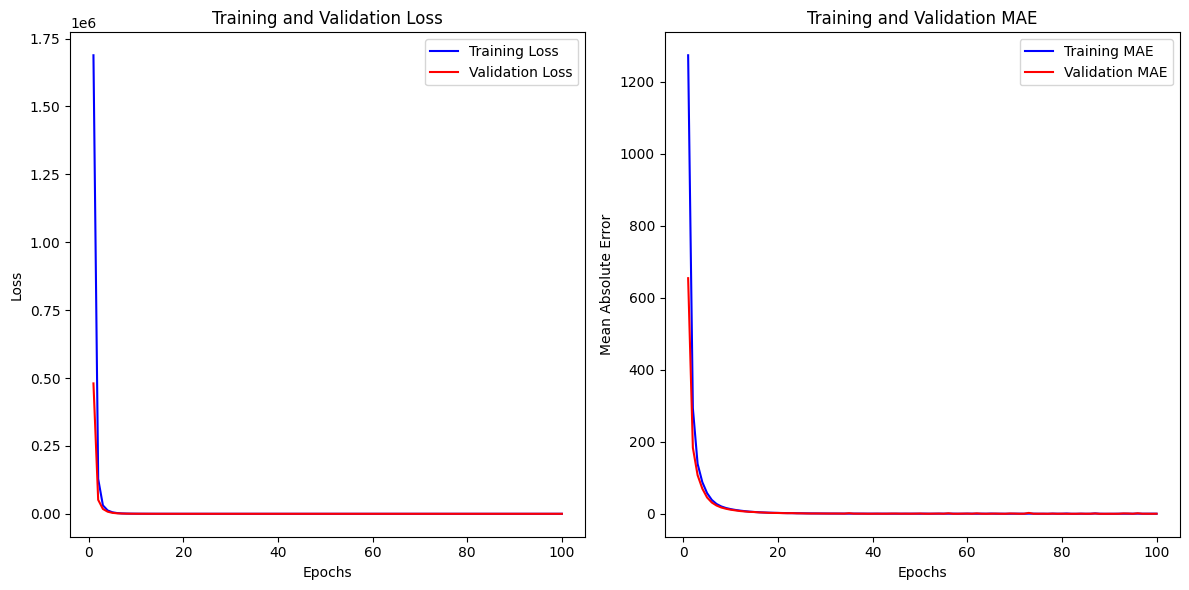

In [17]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

## **10. Saving the Model**

In [11]:
model.save('regression_model.h5')
